# SI 618 - Homework #7: Classifiers
or: How I Learned to Stop Worrying and Love Machine Learning

Version 2023.11.08.1.CT

This is, perhaps, one of the most exciting homework assignments that you have encountered in this course!

You are going to try your hand at a Kaggle competition to predict which passengers on board the Spaceship Titanic are transported to an alternate dimension.

You can access the competition here: **https://www.kaggle.com/c/spaceship-titanic**

This assignment is similar to the Kaggle competition that we did in class, but it uses a different and larger dataset.

The basic steps for this assignment are the same as what we did in class:

1. Accept the rules and join the competition
2. Download the data (from the data tab of the competition page)
3. Understand the problem
4. EDA (Exploratory Data Analysis)
5. Train, tune, and ensemble (!) your machine learning models
6. Upload your prediction as a submission on Kaggle and receive an accuracy score

additionally, you will

7. Upload your final notebook to Canvas and report your best accuracy score.  

Note that class grades are not entirely dependent on your accuracy score.  
All models that achieve 80% accuracy will receive full points for 
the accuracy component of this assignment.

Rubric:

1. (20 points) Conduct an EDA. You must demonstrate that you understand the data and the problem.
2. (60 points) Train, tune, and ensemble machine learning models.  You must use at least 3 different models, and you must ensemble them in some way.  You must also tune your models to improve accuracy.
4. (10 points) Accuracy score based on Kaggle submission report (or alternative, see NOTE above).
5. (10 points) PEP-8, grammar, spelling, style, etc.

Some additional notes:

1. If you use another notebook, code, or approaches be sure to reference the original work. (Note that we recommend you study existing Kaggle notebooks before starting your own work.)
2. You can help each other but in the end you must submit your own work, both to Kaggle and to Canvas.

Some additional resources:

* "ensemble" your models with a [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)
* a good primer on [feature engineering](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)
* There are a lot of good [notebooks to study](https://www.kaggle.com/competitions/spaceship-titanic/code) (check the number of upvotes to help guide your exploration), but be careful to cite any code that you use, and be careful to not accidentally (or intentionally) cheat.

## GOOD LUCK!
(and don't cheat)

One final note:  Your submission should be a self-contained notebook that is NOT based
on this one.  Studying the existing Kaggle competition notebooks should 
give you a sense of what makes a "good" notebook.

# Import Packages

In [1081]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE


from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    VotingClassifier,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# Data Cleaning and EDA

In [1082]:
# Load the data
test_df = pd.read_csv("../data/spaceship_titanic/test.csv")
train_df = pd.read_csv("../data/spaceship_titanic/train.csv")
submission_csv = pd.read_csv("../data/spaceship_titanic/sample_submission.csv")

In [1083]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [1084]:
print(
    f"The train dataset has {train_df.shape[0]} rows and {train_df.shape[1]} columns\n"
)
train_df.info()

The train dataset has 8693 rows and 14 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


## Feature Engineering

### Cabin Information

In [1085]:
def seperate_cabin_data(df):
    """
    This function will seperate the cabin data into three columns: Deck, CabinNum, and Side

    Parameters
    ----------
    df: pandas dataframe
        The dataframe that contains the cabin data

    Returns
    -------
    df: pandas dataframe
        The dataframe that contains the cabin data seperated into three columns
    """
    df["Cabin"] = df["Cabin"].str.split("/")
    df["Deck"], df["CabinNum"], df["Side"] = (
        df["Cabin"].str[0],
        df["Cabin"].str[1].astype(float),
        df["Cabin"].str[2],
    )
    df.drop("Cabin", axis=1, inplace=True)
    return df

In [1086]:
# Seperate Cabin into Deck, Room, Side
test_df = seperate_cabin_data(test_df)
train_df = seperate_cabin_data(train_df)

In [1087]:
def calc_total_spending(df):
    """
    This function will calculate the total spending of each passenger

    Parameters
    ----------
    df: pandas dataframe
        The dataframe that contains the spending data

    Returns
    -------
    df: pandas dataframe
        The dataframe that contains the total spending data
    """
    df["TotalSpending"] = (
        df["RoomService"]
        + df["FoodCourt"]
        + df["ShoppingMall"]
        + df["Spa"]
        + df["VRDeck"]
    )
    return df

In [1088]:
# Create total spending column
train_df = calc_total_spending(train_df)
test_df = calc_total_spending(test_df)

In [1089]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,CabinNum,Side,TotalSpending
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0.0,P,0.0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0.0,S,736.0
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0.0,S,10383.0
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0.0,S,5176.0
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1.0,S,1091.0


### Family Size

Here we are making the assumption that if the passengers have the same last name that they are a part of the same family. The family size is the number of people in the family including the passenger.

This data is added in a new column `FamilySize`.

In [1090]:
def find_family_size(df):
    df["FamilyName"] = df["Name"].str.split(" ").str[1]
    df["FamilySize"] = df.groupby("FamilyName")["FamilyName"].transform(
        "count"
    )
    df.drop("FamilyName", axis=1, inplace=True)
    return df

In [1091]:
train_df = find_family_size(train_df)
test_df = find_family_size(test_df)
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,CabinNum,Side,TotalSpending,FamilySize
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0.0,P,0.0,1.0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0.0,S,736.0,4.0
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0.0,S,10383.0,6.0
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0.0,S,5176.0,6.0
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1.0,S,1091.0,6.0


## Passenger Group and Number of people in group

The PassengerId follows the format gggg_pp where gggg is the group number and pp is the number of people in the group. This data is added in a new column `PassengerGroup` and `GroupSize`.

In [1092]:
def find_group_info(df):
    """
    This function will find the group size and group number of each passenger

    Parameters
    ----------
    df: pandas dataframe
        The dataframe that contains the passenger id

    Returns
    -------
    df: pandas dataframe
        The dataframe that contains the group size and group number of each passenger
    """
    df["GroupSize"] = df["PassengerId"].str.split("_").str[1].astype(int)
    df["GroupNum"] = df["PassengerId"].str.split("_").str[0].astype(int)
    return df

In [1093]:
train_df = find_group_info(train_df)
test_df = find_group_info(test_df)
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,CabinNum,Side,TotalSpending,FamilySize,GroupSize,GroupNum
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0.0,P,0.0,1.0,1,1
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0.0,S,736.0,4.0,1,2
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0.0,S,10383.0,6.0,1,3
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0.0,S,5176.0,6.0,2,3
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1.0,S,1091.0,6.0,1,4


## Null Value Analysis


In [1094]:
train_df.isna().sum()

PassengerId        0
HomePlanet       201
CryoSleep        217
Destination      182
Age              179
VIP              203
RoomService      181
FoodCourt        183
ShoppingMall     208
Spa              183
VRDeck           188
Name             200
Transported        0
Deck             199
CabinNum         199
Side             199
TotalSpending    908
FamilySize       200
GroupSize          0
GroupNum           0
dtype: int64

# Exploritory Data Analysis

## Value of Interest: Transported

In [1095]:
train_df["Transported"].value_counts()

Transported
True     4378
False    4315
Name: count, dtype: int64

<Axes: xlabel='Transported', ylabel='count'>

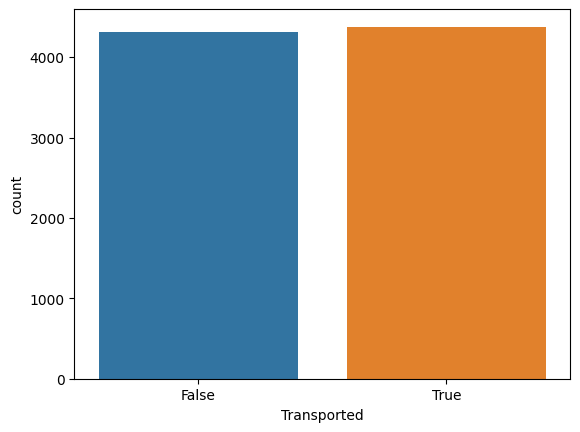

In [1096]:
sns.countplot(x="Transported", data=train_df)

Our goal is to predict whether or not a passenger is transported.

The numbert of passengers tranported and not transported are very similar with no significant difference.

Transported: 4378
Not Transported: 4315



### Numerical Variables

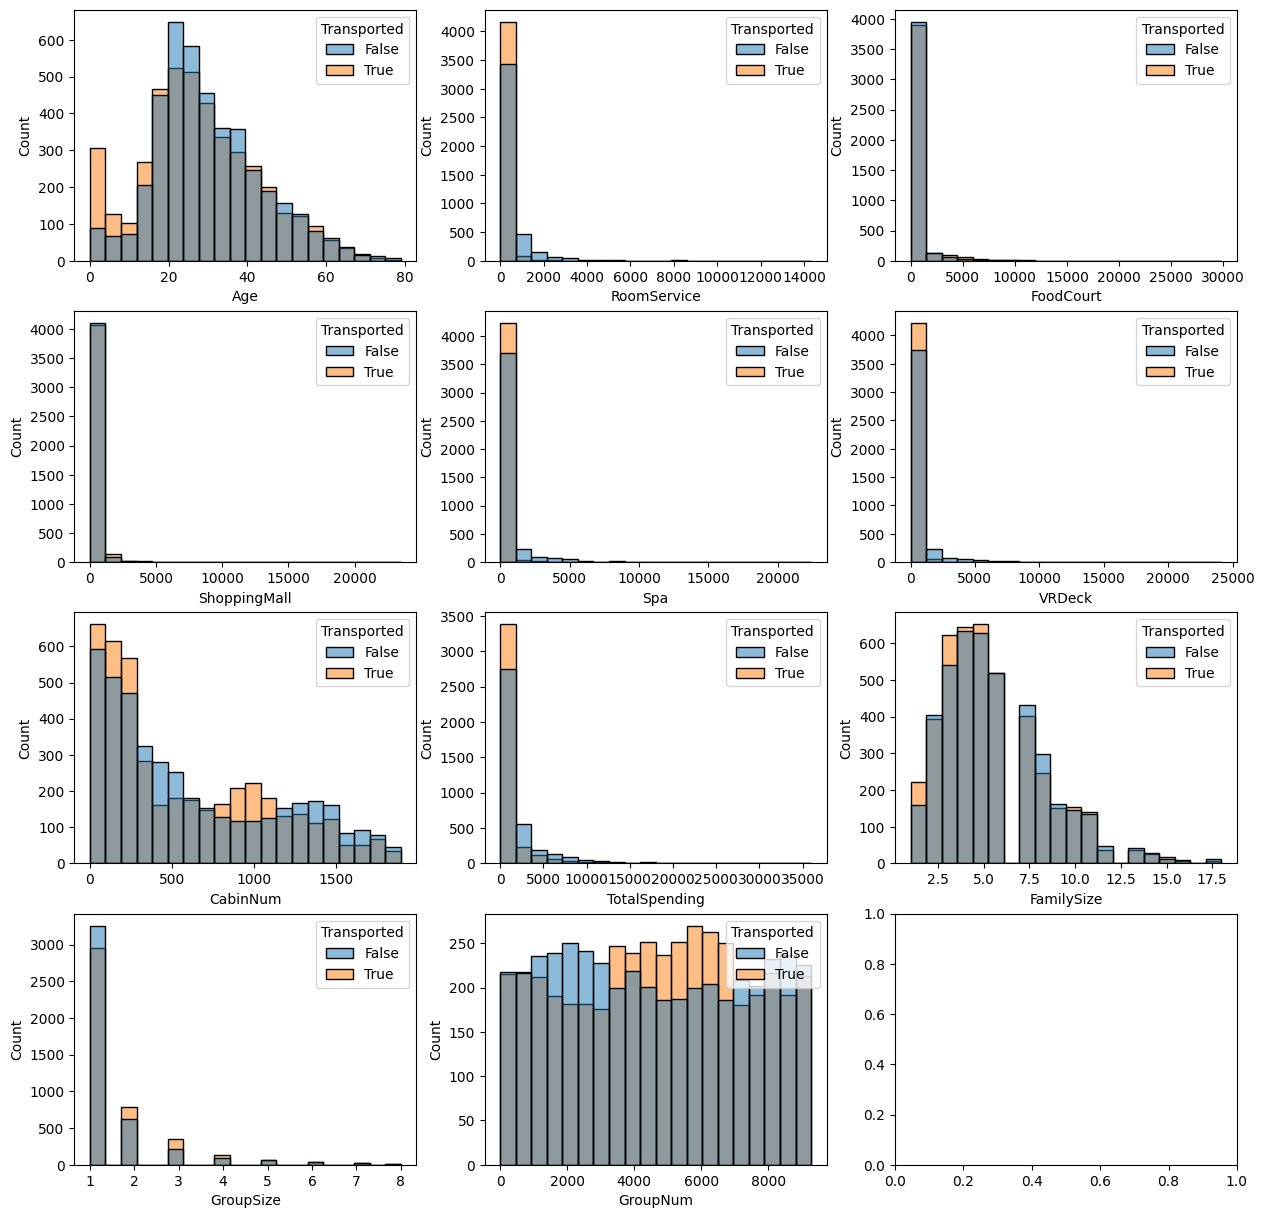

In [1097]:
numeric_vars = train_df.select_dtypes(include="number").columns.tolist()

# Creates histograms for all numeric variables with seperate by Transported
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
for i, ax in enumerate(axes.flatten()):
    if i < len(numeric_vars):
        sns.histplot(
            data=train_df,
            x=numeric_vars[i],
            hue="Transported",
            ax=ax,
            bins=20,
        )

### Spending Categories

There are 6 spending categories: **RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck**, and **TotalSpending**

Based on the distributions of our numerical variables, we can see that the spending categories are skewed to the right. This is expected as most people will spend less than the average. The distributions of the spending categories are similar to each other. The distributions of the spending categories are also similar to the distribution of the total spending. This is expected as the spending categories are a subset of the total spending.

These Columns may benefit from a log transformation or being split into bins.

The passengers with the lowest spending for TotalSpending, VRDeck, Spa, and RoomService appear to have a higher rate of being transported, while those with the lowest spending for ShoppingMall and FoodCourt appear to have a lower rate of being transported.

In [1098]:
spending_cats = [
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "TotalSpending",
]
train_df[spending_cats].describe()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalSpending
count,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,7785.000000
mean,224.687617,458.077203,173.729169,311.138778,304.854791,1484.601541
std,666.717663,1611.489240,604.696458,1136.705535,1145.717189,2845.288241
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,736.000000
75%,47.000000,76.000000,27.000000,59.000000,46.000000,1486.000000
max,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,35987.000000


We can see that for all spending categories most passengers spent 0 at all categories. We can bin our data into groups containing 0, between  0 and 75% percentile, and above 75% percentile.

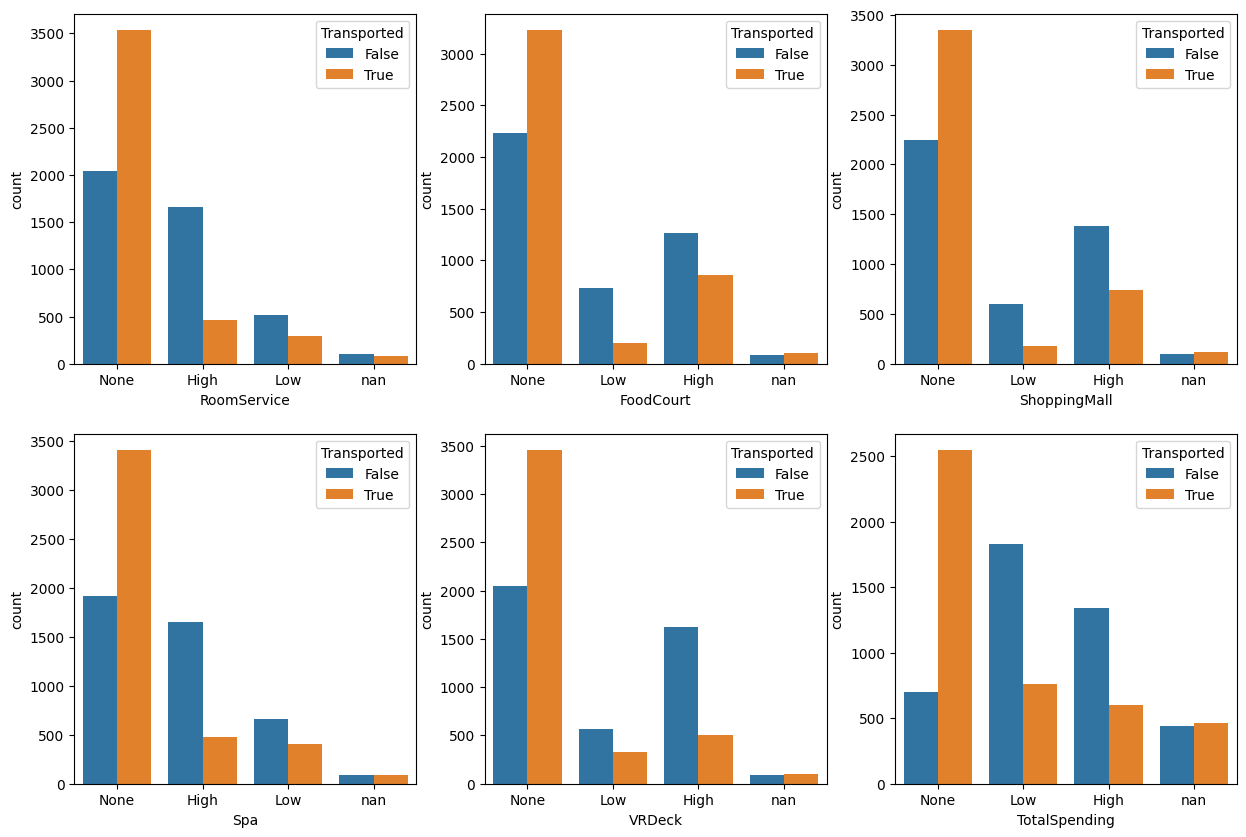

In [1099]:
spending_cats = [
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "TotalSpending",
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for col in spending_cats:
    train_df[col] = pd.cut(
        train_df[col],
        bins=[-1, 0, train_df[col].quantile(0.75), train_df[col].max()],
        labels=["None", "Low", "High"],
    )
    train_df[col] = train_df[col].astype(str)
    test_df[col] = pd.cut(
        test_df[col],
        bins=[-1, 0, test_df[col].quantile(0.75), test_df[col].max()],
        labels=["None", "Low", "High"],
    )
    test_df[col] = test_df[col].astype(str)

for i, ax in enumerate(axes.flatten()):
    sns.countplot(data=train_df, x=spending_cats[i], hue="Transported", ax=ax)
plt.show()

After binning our data we can see that the three groups  selected does a decent job of creating three distinct groups based on the transport rate. 

For all spending categories passengers who spent none were signifigantly more likely to be transported. Additionally, passengers who spent more than the 75% percentile were signifigantly less likely to be transported.

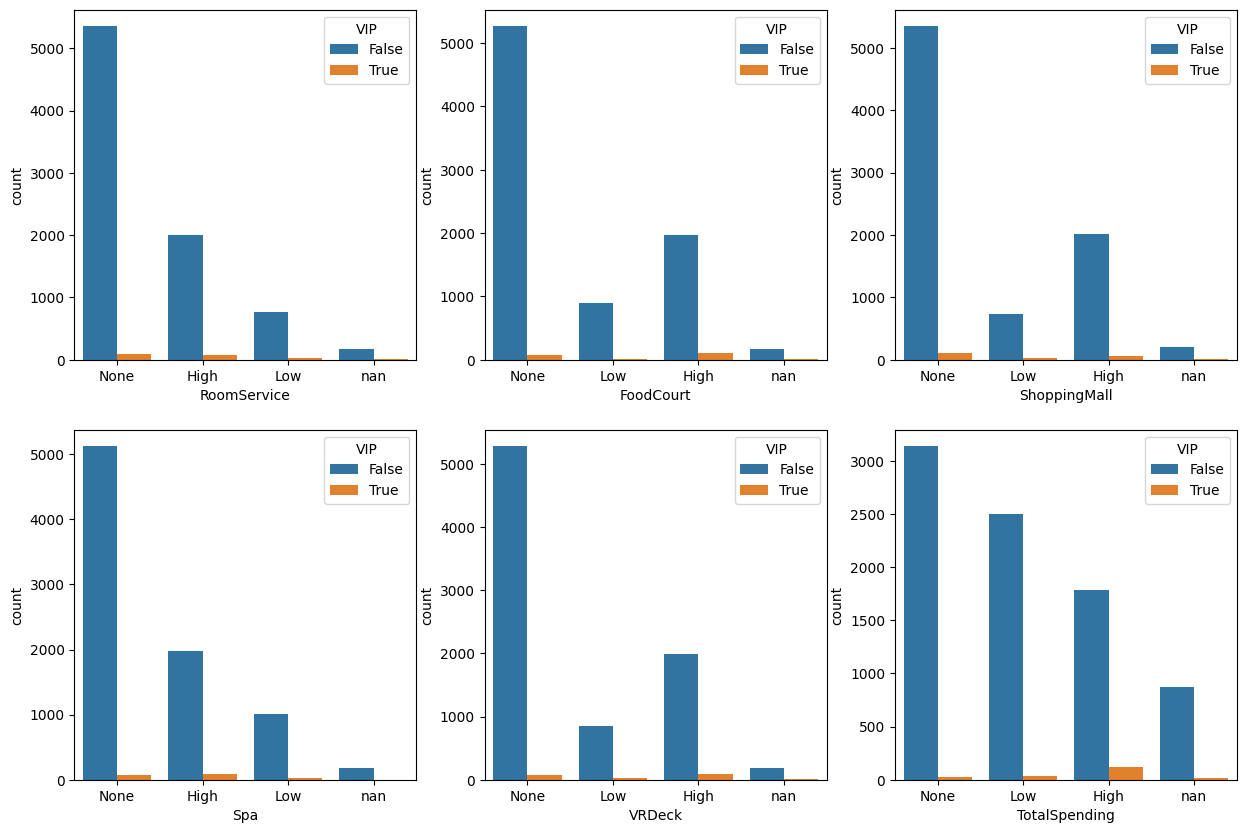

In [1100]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, ax in enumerate(axes.flatten()):
    sns.countplot(data=train_df, x=spending_cats[i], hue="VIP", ax=ax)
plt.show()

### Age
Based on the distribution of Age it appears that those with an age of less than 20 were more likely to be transported.

Passengers with an age between 20 and 40 were more likely to be transported.

Passengers with an age greater than 40 showed less difference for those transported and those not. 

### Cabin Number
The distribution of Cabin number reveals interesting information for being transported or not. 

Passsengers with cabin numbers between 0 and 250, and 750 and 1100 were more likely to be transported. Passengers not within those ranges were less likely to be transported. 

### Family Size

Based on the distribution of Family Size, it appears that passengers with a family size less than 5 were more likely to be transported. 

The difference between passengers who were transported and not is smaller for Family size than other  variables

### Group Size

Passengers with a groupsize (as indicated by their ticket) of 1, were less likely to be transported. 

Those with a group size greater than 1 were more likely to be transported.



### Categorical Variables

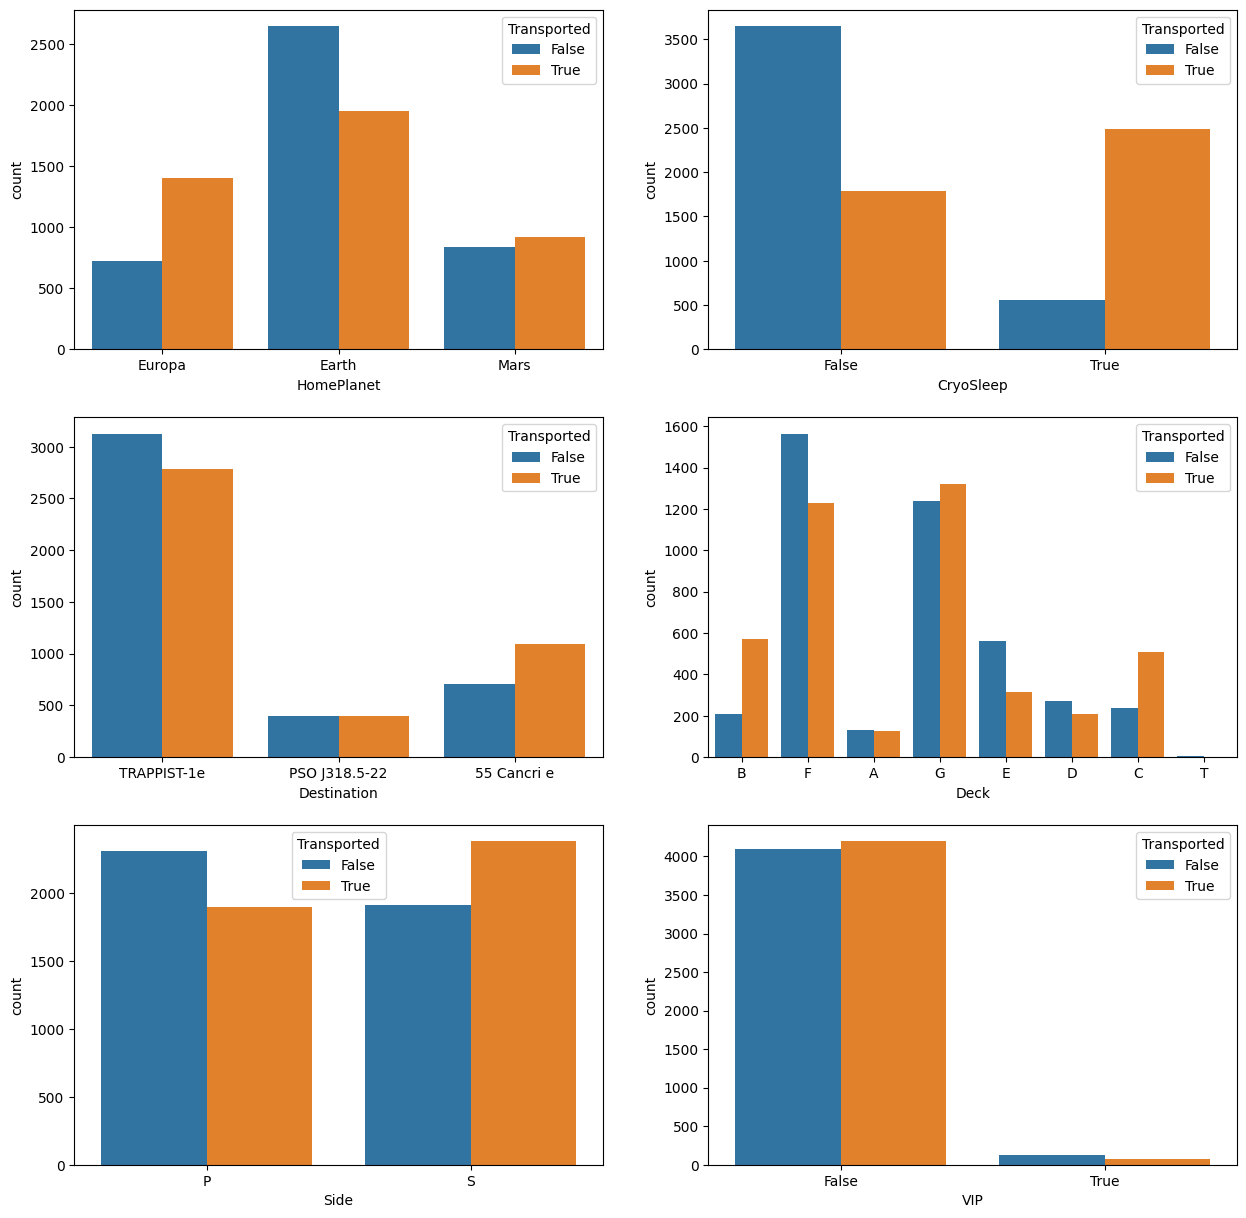

In [1101]:
# Take out spending cateogries and transported as they have already been analyzed
cat_vars = ["HomePlanet", "CryoSleep", "Destination", "Deck", "Side", "VIP"]

# Creates bar plots for all categorical variables with seperate by Transported
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
for i, ax in enumerate(axes.flatten()):
    if i < len(cat_vars):
        sns.countplot(
            data=train_df,
            x=cat_vars[i],
            hue="Transported",
            ax=ax,
        )

## Eliminating Variables
### VIP
The VIP variable shows the majority of the passengers not having VIP, and no signifigant difference in survival rate between VIP and non-VIP passengers.

Because of this we will drop this row from our dataset as it will not be useful in our model.

### Cabin
The Cabin variable has been previously eliminated in favor of the Deck, Side, and Num variables that were created from it.

### PassengerId
The PassengerId variable is a unique identifier for each passenger and will not be useful in our model.

### Name
The Name variable is a unique identifier for each passenger and will not be useful in our model.


In [1102]:
train_df.drop(["Name", "VIP", "PassengerId"], axis=1, inplace=True)

test_df.drop(["Name", "VIP", "PassengerId"], axis=1, inplace=True)

train_df.head()

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,CabinNum,Side,TotalSpending,FamilySize,GroupSize,GroupNum
0,Europa,False,TRAPPIST-1e,39.0,None,None,None,None,None,False,B,0.0,P,None,1.0,1,1
1,Earth,False,TRAPPIST-1e,24.0,High,Low,Low,High,Low,True,F,0.0,S,Low,4.0,1,2
2,Europa,False,TRAPPIST-1e,58.0,Low,High,None,High,High,False,A,0.0,S,High,6.0,1,3
3,Europa,False,TRAPPIST-1e,33.0,None,High,High,High,High,False,A,0.0,S,High,6.0,2,3
4,Earth,False,TRAPPIST-1e,16.0,High,Low,High,High,Low,True,F,1.0,S,Low,6.0,1,4


# Null Value Imputation

we will create clusters with our data, then impute null values with the median from the cluster they are in

In [1103]:
# Resetablish our numeric and categorical variables with the dropped columns
numeric_vars = train_df.select_dtypes(include="number").columns.tolist()
cat_vars = train_df.select_dtypes(exclude="number").columns.tolist()

In [1104]:
# All columns have missing values except for transported
train_df.isna().sum()

HomePlanet       201
CryoSleep        217
Destination      182
Age              179
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Transported        0
Deck             199
CabinNum         199
Side             199
TotalSpending      0
FamilySize       200
GroupSize          0
GroupNum           0
dtype: int64

In [1105]:
it_imp = IterativeImputer(
    initial_strategy="median", random_state=42, max_iter=10
)

# Impute missing values with median for numerical and mode for categorical

for col in train_df.columns:

    if col in cat_vars:

        train_df[col].fillna(train_df[col].mode()[0], inplace=True)


# Do the impuation again for  test_df
for col in test_df.columns:
    if col in cat_vars:
        test_df[col].fillna(test_df[col].mode()[0], inplace=True)

train_df[numeric_vars] = it_imp.fit_transform(train_df[numeric_vars])
test_df[numeric_vars] = it_imp.transform(test_df[numeric_vars])


train_df.isna().sum()

HomePlanet       0
CryoSleep        0
Destination      0
Age              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Transported      0
Deck             0
CabinNum         0
Side             0
TotalSpending    0
FamilySize       0
GroupSize        0
GroupNum         0
dtype: int64

In [1106]:
train_df.head()

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,CabinNum,Side,TotalSpending,FamilySize,GroupSize,GroupNum
0,Europa,False,TRAPPIST-1e,39.0,None,None,None,None,None,False,B,0.0,P,None,1.0,1.0,1.0
1,Earth,False,TRAPPIST-1e,24.0,High,Low,Low,High,Low,True,F,0.0,S,Low,4.0,1.0,2.0
2,Europa,False,TRAPPIST-1e,58.0,Low,High,None,High,High,False,A,0.0,S,High,6.0,1.0,3.0
3,Europa,False,TRAPPIST-1e,33.0,None,High,High,High,High,False,A,0.0,S,High,6.0,2.0,3.0
4,Earth,False,TRAPPIST-1e,16.0,High,Low,High,High,Low,True,F,1.0,S,Low,6.0,1.0,4.0


# Model Training

In [1107]:
# Our labels are the transported column
labels = ["Transported"]

# Remove labels from cat_vars
cat_vars.remove(labels[0])

# Our features are everything else

X = train_df.copy().drop(labels, axis=1)

y = train_df[labels]

In [1108]:
# Identify our classifiers for voting classifier
classifier_names = [
    "Logistic Regression",
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
]

classifiers = [
    ("lr", LogisticRegression()),
    ("KNN", KNeighborsClassifier(3)),
    ("SVClin", SVC(kernel="linear", C=0.025)),
    ("SVC", SVC(gamma=2, C=1)),
    ("gaus", GaussianProcessClassifier(1.0 * RBF(1.0))),
    ("decTree", DecisionTreeClassifier(max_depth=5)),
    (
        "ranForest",
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    ),
    ("MLP", MLPClassifier(alpha=1, max_iter=1000)),
    ("ada", AdaBoostClassifier()),
    ("gausNB", GaussianNB()),
]

classifiers = [
    ("lr", LogisticRegression()),
    ("KNN", KNeighborsClassifier(3)),
    ("SVClin", SVC(kernel="linear", C=0.025)),
    (
        "ranForest",
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    ),
]

In [1109]:
# One hot encode categorical variables and scale numerical variables
pipe0 = ColumnTransformer(

    [

        ("OneHot", OneHotEncoder(), cat_vars),

        ("scale", StandardScaler(), numeric_vars),

    ]
)

In [1110]:
pipe2 = Pipeline(
    [
        ("preprocess", pipe0),
        (
            "voting",
            VotingClassifier(
                estimators=classifiers, voting="hard", n_jobs=-1, verbose=True
            ),
        ),
    ]
)

In [1111]:
voting = pipe2.fit_transform(X, y)

c:\Users\Matt\Documents\GitHub\si618classwork\.venv\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Matt\Documents\GitHub\si618classwork\.venv\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [1112]:
X_test = test_df.copy()

In [1113]:
pipe2.score(X, y)

0.7784424249396066

In [1114]:
y_pred = pipe2.predict(X_test)
y_pred

array([ True, False,  True, ...,  True, False,  True])

In [1119]:
pipe2.score(X_test, y_pred)

1.0

In [1115]:
scores = cross_val_score(pipe2, X, y, cv=10)
print(
    "Accuracy: %0.2f%% (+/- %0.2f)"
    % (scores.mean() * 100, scores.std() * 2 * 100)
)

c:\Users\Matt\Documents\GitHub\si618classwork\.venv\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Matt\Documents\GitHub\si618classwork\.venv\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\Matt\Documents\GitHub\si618classwork\.venv\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Matt\Documents\GitHub\si618classwork\.venv\lib\site-packages\sklearn\preproces

Accuracy: 75.39% (+/- 3.23)


# Submission

In [1116]:
submission = pd.read_csv("../data/spaceship_titanic/sample_submission.csv")

In [1117]:
submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [1118]:
submission["Transported"] = y_pred

In [1121]:
submission.to_csv("../data/spaceship_titanic/submission.csv", index=False)